#INSTALLATION AND IMPORTS

In [ ]:
# GPU allowance
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import os
import random
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
from skimage import io, color, feature

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import *


import tensorflow as tf

from keras.models import *
from keras.layers import *
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.utils import plot_model, to_categorical
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


#link to dataset:
https://drive.google.com/drive/folders/1V1f5lrD7BKG5Az59Cq7mTottRT-UBV3H?usp=sharing

* change the path according to where you will put the dataset folder.
* please avoid changing any name

In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)
path='drive/MyDrive/Img/'


Mounted at /content/drive/


In [ ]:
with open(path + 'all.txt') as f:
  images_path = [line.rstrip() for line in f.readlines()]
width,height = 256,256
df = pd.DataFrame({'Labels':[0]*55 +[1]*55 +[2]*55 +[3]*55 +
                   [4]*55 +[5]*55 +[6]*55 +[7]*55 +[8]*55 +
                   [9]*55 +['A']*55 +['B']*55 +['C']*55 +
                   ['D']*55 +['E']*55 +['F']*55 +['G']*55 +
                   ['H']*55 +['I']*55 +['J']*55 +['K']*55 +
                   ['L']*55 +['M']*55 +['N']*55 +['O']*55 +
                   ['P']*55 +['Q']*55 +['R']*55 +['S']*55 +
                   ['T']*55 +['U']*55 +['V']*55 +['W']*55 +
                   ['X']*55 +['Y']*55 +['Z']*55 +['a']*55 +
                   ['b']*55 +['c']*55 +['d']*55 +['e']*55 +
                   ['f']*55 +['g']*55 +['h']*55 +['i']*55 +
                   ['j']*55 +['k']*55 +['l']*55 +['m']*55 +
                   ['n']*55 +['o']*55 +['p']*55 +['q']*55 +
                   ['r']*55 +['s']*55 +['t']*55 +['u']*55 +
                   ['v']*55 +['w']*55 +['x']*55 +['y']*55 +
                   ['z']*55})

mapping = {val: i for i, val in enumerate(df['Labels'].unique())}

# Apply the mapping to the column to get numerical values
df['Labels'] = df['Labels'].apply(lambda x: mapping[x])
df['Labels'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61])

In [ ]:
def pre_proc(path,width,height):
  img = cv2.imread(path,0)/255 +1
  img[img>1] = 0
  kernel = np.ones((7,7),np.uint8)
  img = cv2.erode(img, kernel, iterations=3)
  img = resize(img,(width,height), mode='constant', preserve_range=True).astype(np.uint8)
  contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
  M = cv2.moments(contours[0])
  cx = int(M['m10']/M['m00'])
  cy = int(M['m01']/M['m00'])

  h, w = img.shape[:2]
  dx = w // 2 - cx
  dy = h // 2 - cy

  M = np.float32([[1, 0, dx], [0, 1, dy]])
  img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))
  return img


In [ ]:
#reading, preprocessing (erosion + tranlastion)

images = np.zeros(((len(images_path)), height, width), dtype=np.uint8)
for i,image in tqdm_notebook(enumerate(images_path),total=len(images_path)):
  images[i] = pre_proc(path + image,width,height)

labels = df.iloc[:,0]

<ipython-input-6-926f08342d42>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i,image in tqdm_notebook(enumerate(images_path),total=len(images_path)):


  0%|          | 0/3410 [00:00<?, ?it/s]

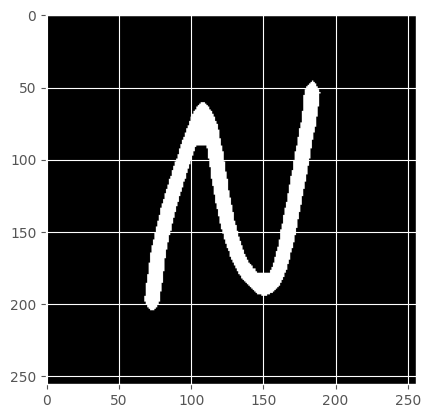

In [ ]:
plt.imshow(images[1265],cmap='gray')

In [ ]:
# Split data into train and test sets
X_train, y_train = images, labels

#skip 
* i used 2 other models but they sucked and they were super heavy 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage import io, color, feature


image_features = np.array([feature.hog(img) for img in images])

# Split the data into training and testing sets
X_train = image_features

# Train an SVM classifier on the training data
svm = SVC(kernel='linear', C=1, gamma='auto')
svm.fit(X_train, y_train)

accuracy = svm.score(X_train, y_train)
print("Accuracy: {:.2f}%".format(accuracy*100))


Accuracy: 100.00%


In [ ]:
import joblib
joblib.dump(svm, 'drive/MyDrive/svm_model.joblib')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


In [ ]:
num_samples = len(images)
num_pixels = images.shape[1] * images.shape[2]
X_train = images.reshape(num_samples, num_pixels)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn.predict(images[0].reshape(1, num_pixels))

array([24])

In [ ]:
import pickle
filename = 'knn_model.sav'
pickle.dump(knn, open(filename, 'wb'))

#MODEL TRAINING
* U - Net

In [ ]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(62, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50)

In [ ]:
model.save('my_cnn_model.h5')